## Narzędzie graficzne

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
from sortedcontainers import SortedSet


TOLERANCE = 0.20

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
          
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [5]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points
        
    def get_points(self):
        return self.points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]

    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
%matplotlib notebook

## 1)

Przygotuj procedurę, pozwalającą wprowadzać w sposób interaktywny kolejne odcinki (reprezentowane przez pary wierzchołków), a także generować losowo zadaną liczbę odcinków z podanego zakresu współrzędnych 2D. Odcinki pionowe powinny być eliminowane i żadna para odcinków nie powinna mieć końców odcinków o tej samej współrzędnej x. Program powinien umożliwiać zapis i odczyt zbioru odcinków.

In [32]:
# def get_lines_from_plot(plot):
#     linesss = []
#     for line in plot.get_added_lines():
#         for line in plot.get_added_lines()[i].lines:
#             linesss.append(line)
#     return linesss

def get_lines_from_plot(plot):
    result=[]
    for line in plot.get_added_lines():
        for l in line.lines:
            result.append(l)
    return result
        

In [7]:
def generate_random_lines(quantity, x_begin,x_end,y_begin,y_end):
    lines = []
    X = set()
    for _ in range(quantity):
        point_1 = (random.uniform(x_begin,x_end),random.uniform(y_begin,y_end))
        point_2 = (random.uniform(x_begin,x_end),random.uniform(y_begin,y_end))
        while (point_1[0]==point_2[0] or point_1[0] in X or point_2[0] in X):
            point_1 = (random.uniform(x_begin,x_end),random.uniform(y_begin,y_end))
            point_2 = (random.uniform(x_begin,x_end),random.uniform(y_begin,y_end))
            if point_1[0]>point_2[0]:
                point_1, point_2 = point_2, point_1
        lines.append((point_1,point_2))
    return lines

In [8]:
import csv
def save_to_file(file_name, lines):
    with open(f"{file_name}.csv", "w") as f:
        f.write(str(lines))
        
def load_from_file(file_name):
    with open(f"{file_name}.json", "r") as f:
        data = f.readlines()
    return data

<IPython.core.display.Javascript object>


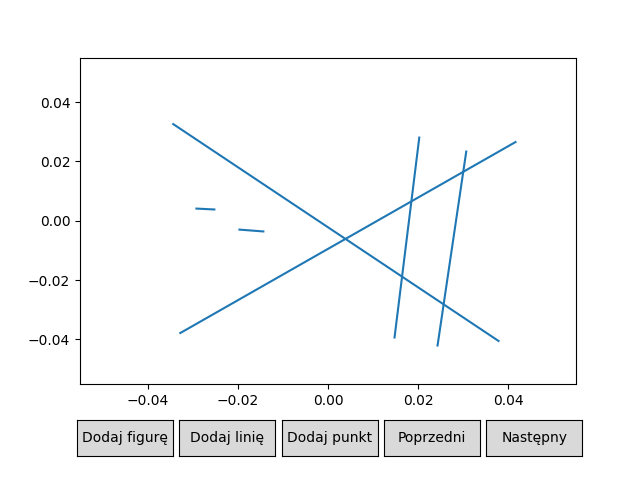

In [37]:
plot = Plot(scenes=[Scene()])
plot.draw()
data_1=[]

In [38]:
data_1=get_lines_from_plot(plot)

<IPython.core.display.Javascript object>


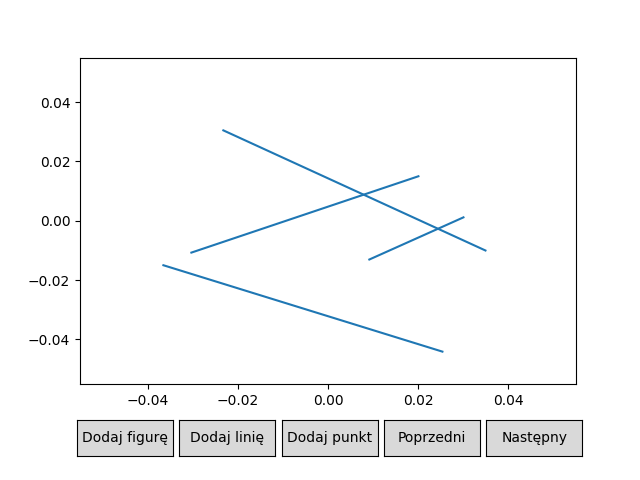

In [39]:
plot = Plot(scenes=[Scene()])
plot.draw()
data_5=[]

In [40]:
data_5=get_lines_from_plot(plot)

<IPython.core.display.Javascript object>


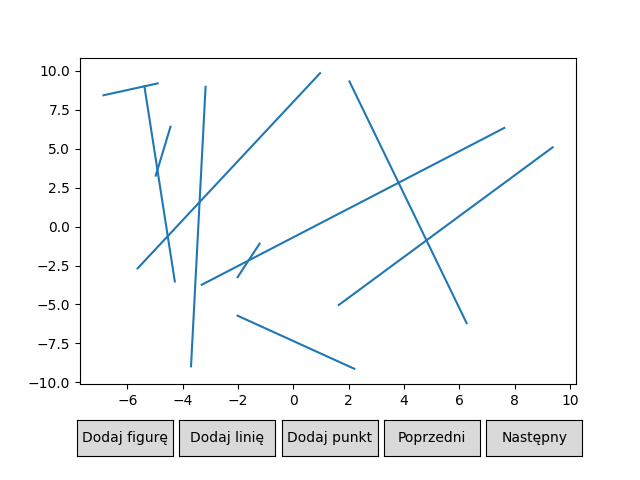

In [28]:
data_2 = generate_random_lines(10,-10,10,-10,10)
plot = Plot([Scene(lines=[LinesCollection(data_2)])])
plot.draw()

<IPython.core.display.Javascript object>


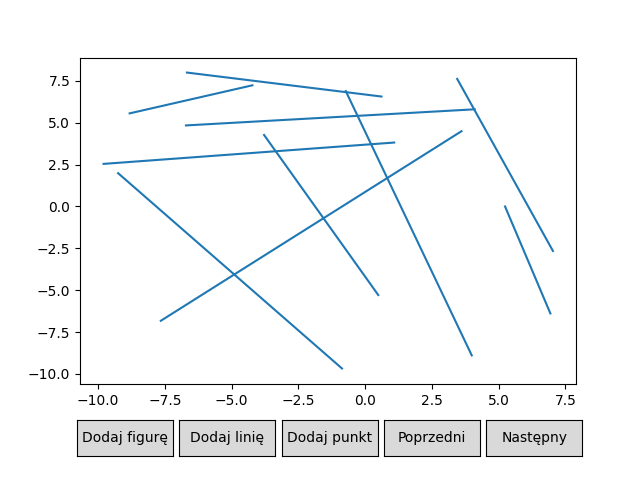

In [8]:
data_3 = generate_random_lines(10,-10,10,-10,10)
plot = Plot([Scene(lines=[LinesCollection(data_3)])])
plot.draw()

<IPython.core.display.Javascript object>


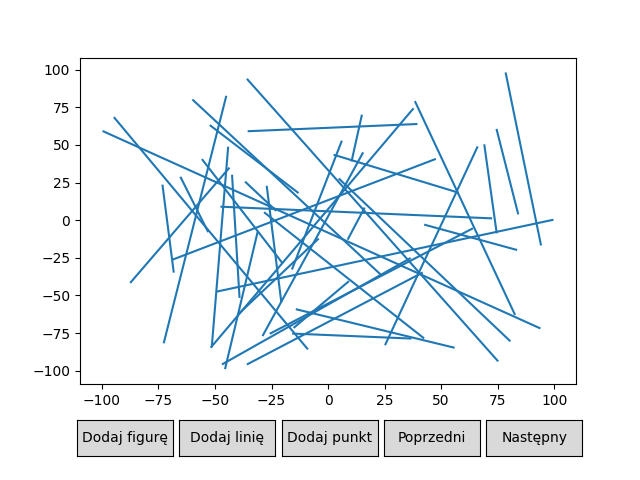

In [9]:
data_4 = generate_random_lines(40,-100,100,-100,100)
plot = Plot([Scene(lines=[LinesCollection(data_4)])])
plot.draw()

## Funkcje sprawdzające punkt przecięcia

## Pomocnicze klasy

In [41]:
class Point:
    def __init__(self, x, y, one, two):
        self.x = x
        self.y = y
        self.one = one
        self.two = two
       
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def __gt__(self, other):
        return self.x < other.x
    


class Line:
    def __init__(self, A, B):
        self.A = A
        self.B = B
        self.a = (self.A.y - self.B.y) / (self.A.x - self.B.x)
        self.b = self.A.y - self.a * self.A.x
        self.x = self.A.x
        
    def __eq__(self, other):
        return self.A == other.A and self.B == other.B
    
    def __hash__(self):
        return hash((self.A, self.B))
    
    def __gt__(self, other):
        return Line.x * self.a + self.b > Line.x * other.a + other.b
    
    def newX(x):
        Line.x = x

In [42]:
def det2x2(one,two):
    return one[0] * two[1] - one[1] * two[0]

def intersection_point(line_one, line_two):
    oneX1 = line_one.A.x
    oneY1 = line_one.A.y
    oneX2 = line_one.B.x
    oneY2 = line_one.B.y
    twoX1 = line_two.A.x
    twoY1 = line_two.A.y
    twoX2 = line_two.B.x
    twoY4 = line_two.B.y
    
    den = det2x2([(oneX1-oneX2), (twoX1-twoX2)], [(oneY1-oneY2), (twoY1-twoY4)])
    
    t = det2x2([(oneX1-twoX1), (twoX1-twoX2)], [(oneY1-twoY1), (twoY1-twoY4)]) / den
    u = -det2x2([(oneX1-oneX2), (oneX1-twoX1)], [(oneY1-oneY2), (oneY1-twoY1)]) / den
    
    if 0 <= t <= 1 and 0 <= u <= 1:
        point = Point(oneX1 + t*(oneX2-oneX1), oneY1 + t*(oneY2-oneY1), line_one.A.one, line_two.A.one)
        return point
    return None

In [43]:
def make_points_and_lines(data):
    points=[]
    lines=[]
    for i in range(len(data)):
        pointOne, pointTwo = data[i]
        firstPoint = Point(pointOne[0],pointOne[1], i, i)
        secondPoint =Point(pointTwo[0],pointTwo[1], i, i)
        if firstPoint.x > secondPoint.x:
            firstPoint, secondPoint = secondPoint, firstPoint
        lines.append(Line(firstPoint,secondPoint))
        points.append(firstPoint)
        points.append(secondPoint)
    return points, lines

def oneIntersection(data):
    
    def check_intersect(l1, l2, p):
        intersect_point = intersection_point(l1, l2)
        if intersect_point is not None:
            cur_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]            
            final_result.append(intersect_point)
            result.append((intersect_point.x,intersect_point.y))
            return True
        return False

    points, lines = make_points_and_lines(data)
    down = float('inf')
    up = - float('inf')
    T = SortedSet()
    Q = SortedSet()
    
    for point in points:
        Q.add(point)
        down = min(down,point.y)
        up = max(up,point.y)
    
    result = []
    scenes = [] 
    final_result = [] 
    Line.newX(Q[-1].x)
    
    while len(Q) > 0:
        p = Q.pop()  
    
        broom = [(p.x, down), (p.x, up)]
        active_lines = []
        for line in T:
            active_lines.append([(line.A.x, line.A.y),(line.B.x, line.B.y)])
        scenes.append(Scene([PointsCollection(result.copy()), PointsCollection([(p.x, p.y)], color='red', marker="D")],
            [LinesCollection(data, color='green'), LinesCollection([broom], color='red'),
            LinesCollection(active_lines.copy(), color='blue')]))
        
        # jeżelie punkt jest początkiem odcinka
        if p == lines[p.one].A:
            Line.newX(p.x)
            # dodaje odcinek do T
            T.add(lines[p.one]) 
            i = T.index(lines[p.one])
            if i-1 >= 0:
                if(check_intersect(T[i-1], T[i], p)):
                    scenes = [Scene([PointsCollection(result.copy())], [LinesCollection(data)])] + scenes
                    return result, final_result, scenes
                    
            if i+1 < len(T):
                if(check_intersect(T[i+1], T[i], p)):
                    scenes = [Scene([PointsCollection(result.copy())], [LinesCollection(data)])] + scenes
                    return result, final_result, scenes
            
            active_lines = []
            for line in T:
                active_lines.append([(line.A.x, line.A.y),(line.B.x, line.B.y)])
            scenes.append(Scene([PointsCollection(result.copy()), PointsCollection([(p.x, p.y)], color='red', marker="D")],
                [LinesCollection(data, color='green'), LinesCollection([broom], color='red'),
                LinesCollection(active_lines.copy(), color='blue')]))
        else:
            if i+1 < len(T) and i-1 >= 0:
                if(check_intersect(T[i+1], T[i-1], p)):
                    scenes = [Scene([PointsCollection(result.copy())], [LinesCollection(data)])] + scenes
                    return result, final_result, scenes
            
            l1 = lines[p.one]
            T.remove(l1)
       
    scenes = [Scene([PointsCollection(result.copy())], [LinesCollection(data)])] + scenes
    return result, final_result, scenes

<IPython.core.display.Javascript object>


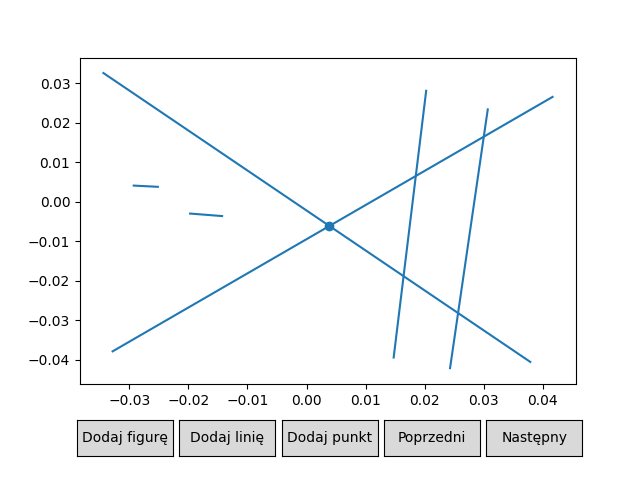

In [45]:
result, final, scenes = oneIntersection(data_1)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


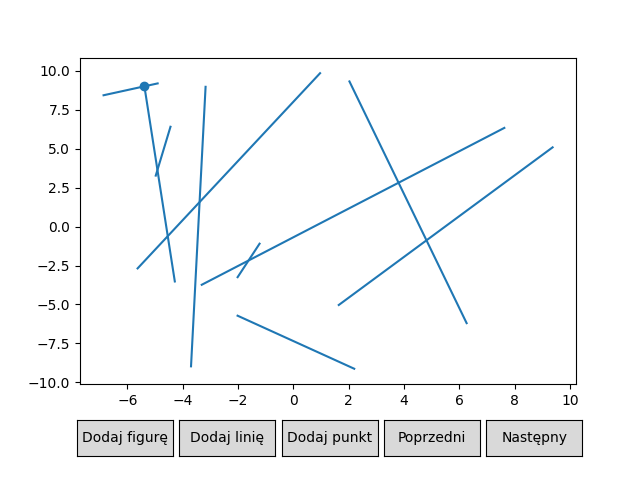

In [29]:
result, final, scenes = oneIntersection(data_2)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


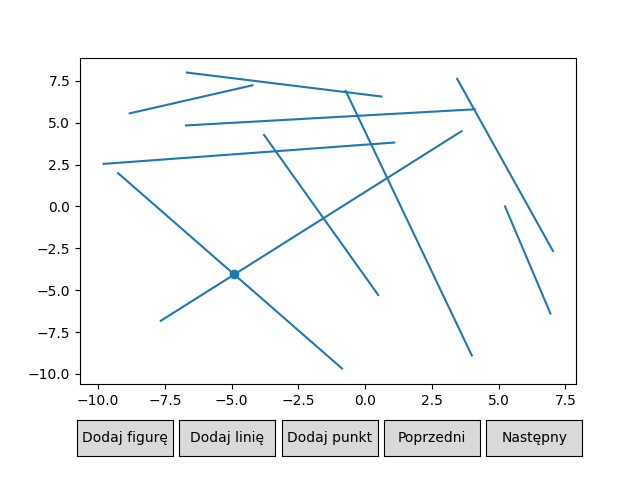

In [39]:
result, final, scenes = oneIntersection(data_3)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


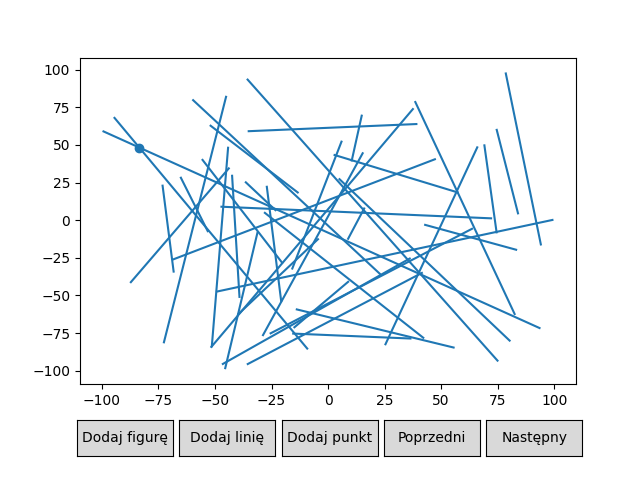

In [40]:
result, final, scenes = oneIntersection(data_4)
plot = Plot(scenes=scenes)
plot.draw()

# Znajdywanie wszystkich przecięć

In [46]:
def find_intersections(lines_raw):

    def check_duplicates(l1, l2):
        i = lines.index(l1)
        j = lines.index(l2)
        for point in final_result:
            if (point.one == i and point.two == j) or (point.one == j and point.two == i):
                return False
        return True
    
    def check_intersect(l1, l2, p):
        intersect_point = intersection_point(l1, l2)
        if intersect_point is not None and intersect_point.x > p.x and check_duplicates(l1, l2):
            Q.add(intersect_point)
            result.append((intersect_point.x,intersect_point.y))
            final_result.append(intersect_point)
            cur_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
            scenes.append(Scene([PointsCollection(result.copy()), PointsCollection([(p.x, p.y)], color='red', marker="D")],
                [LinesCollection(lines_raw, color='green'), LinesCollection([broom], color='red'),
                 LinesCollection(cur_lines.copy(), color='blue')]))
    
    points, lines = make_points_and_lines(lines_raw)
    
    down = float('inf')
    up = - float('inf')
    T = SortedSet()
    Q = SortedSet()
    
    for point in points:
        Q.add(point)
        down = min(down,point.y)
        up = max(up,point.y)     

    result = []
    final_result = []
    scenes = []
    Line.newX(Q[-1].x)

    while len(Q) > 0:
        p = Q.pop()  
    
        broom = [(p.x, down), (p.x, up)]
        cur_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
        scenes.append(Scene([PointsCollection(result.copy()), PointsCollection([(p.x, p.y)], color='red', marker="D")],
            [LinesCollection(lines_raw, color='green'), LinesCollection([broom], color='red'),
             LinesCollection(cur_lines.copy(), color='blue')]))
        
        if p.one != p.two:  
            l1 = lines[p.one]
            l2 = lines[p.two]
            T.remove(lines[p.one])
            T.remove(lines[p.two])
            Line.newX(p.x+0.00001)
            T.add(lines[p.one])
            T.add(lines[p.two])
            i = T.index(lines[p.one])
            j = T.index(lines[p.two])
            
            if i > j:
                i, j = j, i
            
            if i-1 >= 0:
                check_intersect(T[i],T[i-1],p)
            if j+1 < len(T):
                check_intersect(T[j],T[j+1],p)
                
            cur_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
            scenes.append(Scene([PointsCollection(result.copy()), PointsCollection([(p.x, p.y)], color='red', marker="D")],
                [LinesCollection(lines_raw, color='green'), LinesCollection([broom], color='red'), 
                 LinesCollection(cur_lines.copy(), color='blue')]))
        
        elif p == lines[p.one].A:

            Line.newX(p.x)
            T.add(lines[p.one]) 
            
            cur_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
            scenes.append(Scene([PointsCollection(result.copy()), PointsCollection([(p.x, p.y)], color='red', marker="D")],
                [LinesCollection(lines_raw, color='green'), LinesCollection([broom], color='red'),
                 LinesCollection(cur_lines.copy(), color='blue')]))
        
            i = T.index(lines[p.one])
            if i-1 >= 0:
                check_intersect(T[i-1], T[i], p)
            if i+1 < len(T):
                check_intersect(T[i+1], T[i], p)
            
        else:
            l1 = lines[p.one]
            i = T.index(l1)
            if i+1 < len(T) and i-1 >= 0:
                check_intersect(T[i+1], T[i-1], p)
            T.remove(l1)
            
       
    scenes = [Scene([PointsCollection(result.copy())], [LinesCollection(lines_raw)])] + scenes
    return result, final_result, scenes

<IPython.core.display.Javascript object>


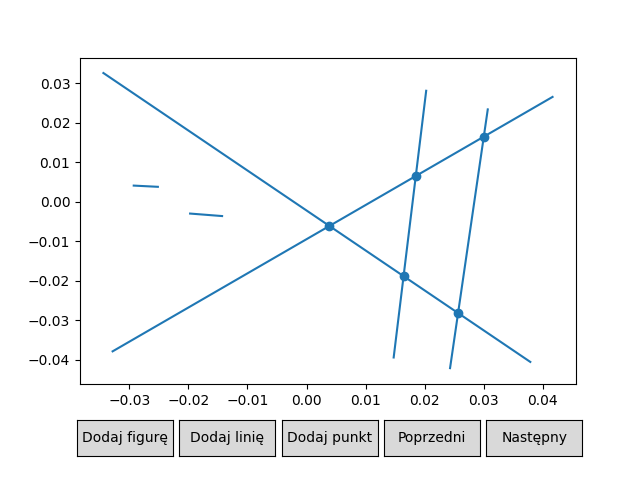

In [48]:
P, final, S =find_intersections(data_1)
plot = Plot(scenes=S)
plot.draw()

<IPython.core.display.Javascript object>


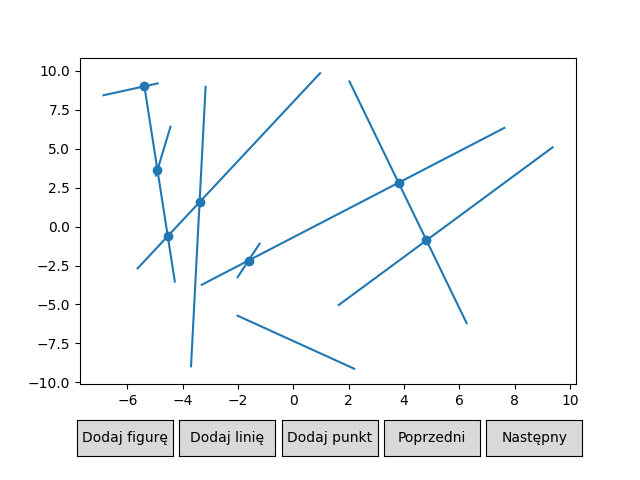

In [34]:
P, final, S =find_intersections(data_2)
plot = Plot(scenes=S)
plot.draw()

<IPython.core.display.Javascript object>


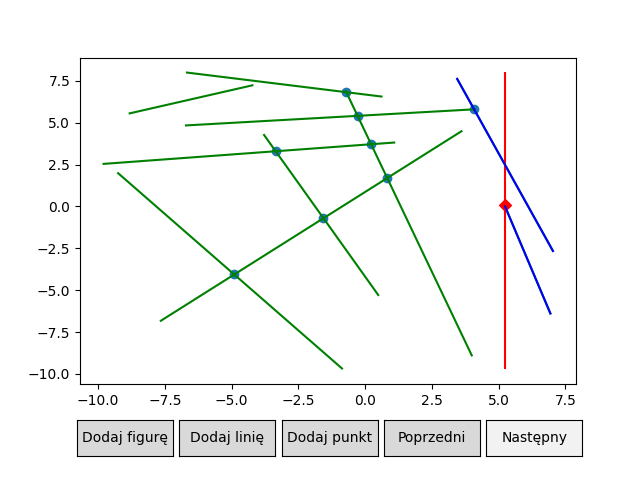

In [41]:
P, final, S =find_intersections(data_3)
plot = Plot(scenes=S)
plot.draw()

<IPython.core.display.Javascript object>


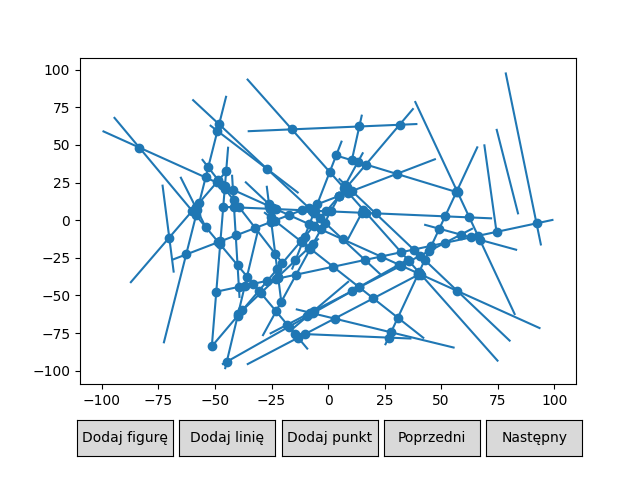

In [24]:
P, final, S =find_intersections(data_4)
plot = Plot(scenes=S)
plot.draw()

<IPython.core.display.Javascript object>


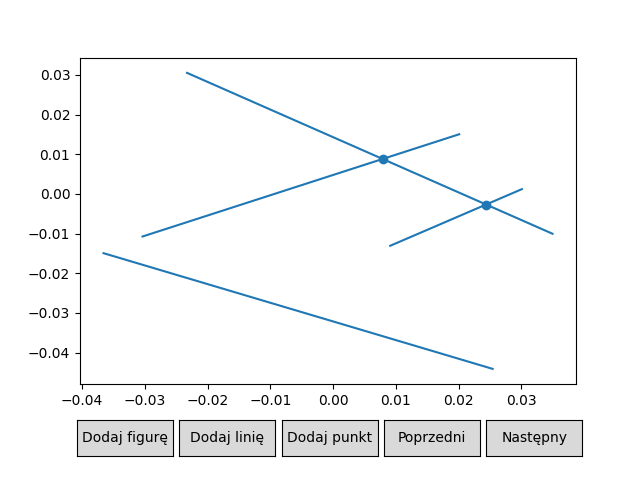

In [50]:
P, final, S =find_intersections(data_5)
plot = Plot(scenes=S)
plot.draw()